## **Dynamic Airline Pricing Optimization: Rule-Based Simulation and Predictive Modeling**

 **Project Introduction:**

In the competitive world of air travel, dynamic pricing plays a critical role in maximizing revenue while maintaining customer satisfaction. This project explores how flight prices vary with features such as timing, demand, and weather, and applies data-driven techniques to simulate and optimize pricing strategies.

Using a real-world-style flight dataset, we:

* Analyzed pricing trends by destination, arrival time, and seat availability.
* Built a linear regression model to predict base ticket prices with high accuracy (R² = 0.91).
* Simulated dynamic pricing rules (e.g., early bird discounts, last-minute markups).
* Compared rule-based prices to actual prices to evaluate effectiveness.
* Incorporated weather conditions into feature correlation analysis.

This end-to-end analysis blends machine learning with practical airline pricing strategies, offering insights into how data science can drive smarter, adaptive pricing in the aviation industry.

This cell installs the `requests` and `streamlit` libraries, which are used for making API calls and building interactive web apps, respectively. The output confirms they are already installed in the current environment.

In [1]:
!pip install requests
!pip install streamlit

This cell imports all necessary libraries for data analysis, modeling, visualization, and API access, including pandas, scikit-learn, matplotlib, and xgboost.

In [2]:
from kaggle.api.kaggle_api_extended import KaggleApi
import numpy as np
import pandas as pd
from datetime import timedelta
import joblib
import matplotlib.pyplot as plt
import os
import requests
import time
from tqdm import tqdm  # optional, for progress bar
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns

Next, we authenticates access to Kaggle using your kaggle.json API key, downloads the “flight-price-dataset” from Kaggle, unzips it, and loads the CSV into a pandas DataFrame named df.

In [3]:
# Step 1: Authenticate using your kaggle.json
api = KaggleApi()
api.authenticate()

# Step 2: Download the dataset and unzip
api.dataset_download_files(
    'orhfusion/flight-price-dataset',
    path='flight_data',
    unzip=True
)

# Step 3: Load the CSV into a DataFrame
df = pd.read_csv("flight_data/Flight Price Prediction.csv")
df.head()

Dataset URL: https://www.kaggle.com/datasets/orhfusion/flight-price-dataset


,Unnamed: 0,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


In the following cell, we fixed simulated flight departure date (2022-03-01), calculates the booking date by subtracting the days_left value from the departure date, and extracts the day of the week for further temporal feature engineering.
Defines the get_season() function, which maps a given month to a season (Winter, Spring, Summer, or Fall) for later use in season-based analysis or modeling.

In [4]:
# Step 1: Fixed simulated departure date
departure_date = pd.to_datetime("2022-03-01")

# Step 2: Derive booking date from days_left
df['booking_date'] = df['days_left'].apply(lambda x: departure_date - timedelta(days=int(x)))
df['departure_date'] = departure_date

# Step 3: Add day of the week
df['day_of_week'] = df['booking_date'].dt.day_name()

# Step 4: Add season
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

df['season'] = df['booking_date'].dt.month.apply(get_season)

# Step 5: Simulate remaining seats (assuming 150 seat capacity)
df['remaining_seats'] = df['days_left'].apply(lambda x: max(5, int(150 * (x / 30))) if x <= 30 else 150)

# Step 6: Calculate inventory pressure (scarcity score)
df['inventory_pressure'] = 1 - (df['remaining_seats'] / 150)

# Preview first row of enriched dataset
df.head()

,Unnamed: 0,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price,booking_date,departure_date,day_of_week,season,remaining_seats,inventory_pressure
0,0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953,2022-02-28,2022-03-01,Monday,Winter,5,0.966667
1,1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953,2022-02-28,2022-03-01,Monday,Winter,5,0.966667
2,2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956,2022-02-28,2022-03-01,Monday,Winter,5,0.966667
3,3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955,2022-02-28,2022-03-01,Monday,Winter,5,0.966667
4,4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955,2022-02-28,2022-03-01,Monday,Winter,5,0.966667


Displays the last few rows of the enriched DataFrame df, showing newly engineered features like booking_date and departure_date.

In [5]:
# Preview last row of enriched dataset
df.tail()

,Unnamed: 0,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price,booking_date,departure_date,day_of_week,season,remaining_seats,inventory_pressure
300148,300148,Vistara,UK-822,Chennai,Morning,one,Evening,Hyderabad,Business,10.08,49,69265,2022-01-11,2022-03-01,Tuesday,Winter,150,0.0
300149,300149,Vistara,UK-826,Chennai,Afternoon,one,Night,Hyderabad,Business,10.42,49,77105,2022-01-11,2022-03-01,Tuesday,Winter,150,0.0
300150,300150,Vistara,UK-832,Chennai,Early_Morning,one,Night,Hyderabad,Business,13.83,49,79099,2022-01-11,2022-03-01,Tuesday,Winter,150,0.0
300151,300151,Vistara,UK-828,Chennai,Early_Morning,one,Evening,Hyderabad,Business,10.00,49,81585,2022-01-11,2022-03-01,Tuesday,Winter,150,0.0
300152,300152,Vistara,UK-822,Chennai,Morning,one,Evening,Hyderabad,Business,10.08,49,81585,2022-01-11,2022-03-01,Tuesday,Winter,150,0.0


Enriches the dataset with historical weather conditions using the Visual Crossing Weather API:

Step 1 extracts unique (destination_city, booking_date) pairs.

Step 2 defines a function to fetch weather data from the API.

Step 3 initializes a local dictionary cache to store fetched results.

Step 4 loops over each unique city-date pair to populate the cache.

Step 5 maps the retrieved weather data back into the main DataFrame under a new column weather_conditions.

In [6]:
API_KEY = '6KNLKNZTDTY9UVVTZDPMUUBHY'  # 🔑 Replace with your Visual Crossing API key

# 1. Create a set of unique (destination_city, booking_date) pairs
unique_queries = df[['destination_city', 'booking_date']].drop_duplicates()

# 2. Define a function to call the API
def fetch_weather(city, date_str):
    url = f"https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline/{city}/{date_str}?unitGroup=metric&key={API_KEY}&include=days"
    try:
        response = requests.get(url)
        if response.status_code == 200:
            return response.json()['days'][0]['conditions']
        else:
            return "Unavailable"
    except:
        return "Unavailable"

# 3. Create a weather cache dictionary
weather_cache = {}

# 4. Fetch weather data in batch
print("Fetching weather data in batches...")
for _, row in tqdm(unique_queries.iterrows(), total=len(unique_queries)):
    city = row['destination_city']
    date_str = pd.to_datetime(row['booking_date']).strftime('%Y-%m-%d')
    key = (city, date_str)
    if key not in weather_cache:
        weather_cache[key] = fetch_weather(city, date_str)
        time.sleep(1)  # to avoid API rate limits

# 5. Map results back to the full DataFrame
df['weather_conditions'] = df.apply(
    lambda x: weather_cache.get((x['destination_city'], x['booking_date'].strftime('%Y-%m-%d')), "Unavailable"),
    axis=1
)

Fetching weather data in batches...


100%|████████████████████████████████████████████████████████████████████████████████| 294/294 [13:04<00:00,  2.67s/it]


The DataFrame now includes enriched contextual features:
- 'weather_conditions': Fetched from the Visual Crossing API based on destination city and booking date.
These features can help improve fare prediction models by capturing seasonal, calendar, and environmental effects on flight demand and pricing.

In [7]:
# Displays a concise summary of the DataFrame, including:
# - Index range
# - Number of non-null entries per column
# - Data types of each column
# - Memory usage
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300153 entries, 0 to 300152
Data columns (total 19 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   Unnamed: 0          300153 non-null  int64         
 1   airline             300153 non-null  object        
 2   flight              300153 non-null  object        
 3   source_city         300153 non-null  object        
 4   departure_time      300153 non-null  object        
 5   stops               300153 non-null  object        
 6   arrival_time        300153 non-null  object        
 7   destination_city    300153 non-null  object        
 8   class               300153 non-null  object        
 9   duration            300153 non-null  float64       
 10  days_left           300153 non-null  int64         
 11  price               300153 non-null  int64         
 12  booking_date        300153 non-null  datetime64[ns]
 13  departure_date      300153 no

In [8]:
# Displays the first 5 rows of the DataFrame.
df.head()

,Unnamed: 0,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price,booking_date,departure_date,day_of_week,season,remaining_seats,inventory_pressure,weather_conditions
0,0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953,2022-02-28,2022-03-01,Monday,Winter,5,0.966667,Clear
1,1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953,2022-02-28,2022-03-01,Monday,Winter,5,0.966667,Clear
2,2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956,2022-02-28,2022-03-01,Monday,Winter,5,0.966667,Clear
3,3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955,2022-02-28,2022-03-01,Monday,Winter,5,0.966667,Clear
4,4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955,2022-02-28,2022-03-01,Monday,Winter,5,0.966667,Clear


In [9]:
# Displays the last 5 rows of the DataFrame.
df.tail()

,Unnamed: 0,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price,booking_date,departure_date,day_of_week,season,remaining_seats,inventory_pressure,weather_conditions
300148,300148,Vistara,UK-822,Chennai,Morning,one,Evening,Hyderabad,Business,10.08,49,69265,2022-01-11,2022-03-01,Tuesday,Winter,150,0.0,"Rain, Partially cloudy"
300149,300149,Vistara,UK-826,Chennai,Afternoon,one,Night,Hyderabad,Business,10.42,49,77105,2022-01-11,2022-03-01,Tuesday,Winter,150,0.0,"Rain, Partially cloudy"
300150,300150,Vistara,UK-832,Chennai,Early_Morning,one,Night,Hyderabad,Business,13.83,49,79099,2022-01-11,2022-03-01,Tuesday,Winter,150,0.0,"Rain, Partially cloudy"
300151,300151,Vistara,UK-828,Chennai,Early_Morning,one,Evening,Hyderabad,Business,10.00,49,81585,2022-01-11,2022-03-01,Tuesday,Winter,150,0.0,"Rain, Partially cloudy"
300152,300152,Vistara,UK-822,Chennai,Morning,one,Evening,Hyderabad,Business,10.08,49,81585,2022-01-11,2022-03-01,Tuesday,Winter,150,0.0,"Rain, Partially cloudy"


## Heatmap of weather conditions and key flight features

In the following cell, we compute and visualize the correlation between weather conditions and key flight features (such as price, duration, days_left, remaining_seats, and inventory_pressure). It uses one-hot encoding for weather conditions (e.g., weather_Rain, weather_Clear) and creates a correlation heatmap using Seaborn.

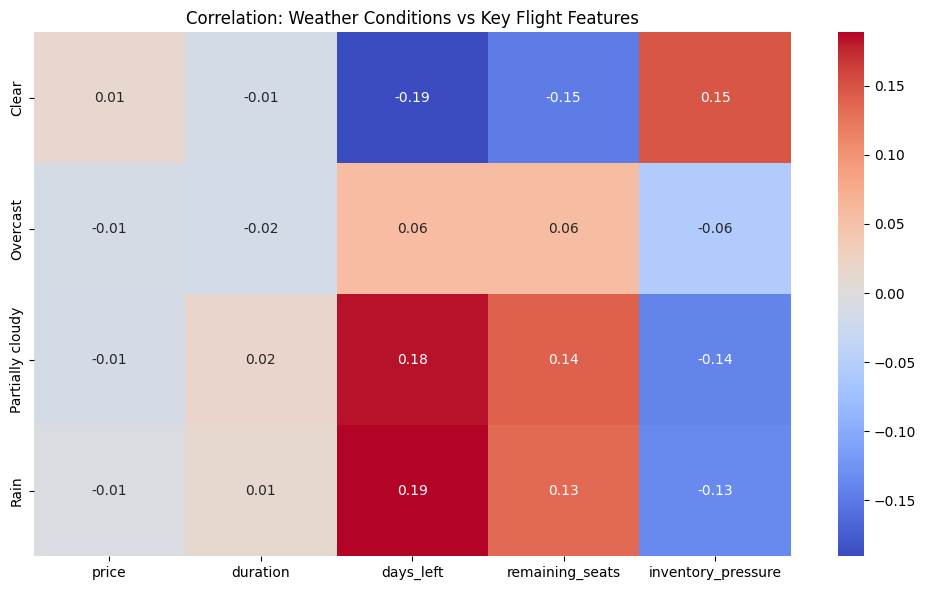

In [10]:
# One-hot encode the weather_conditions column (multi-label)
weather_dummies = df['weather_conditions'].str.get_dummies(sep=', ')

# Select numerical columns
numeric_cols = ['price', 'duration', 'days_left', 'remaining_seats', 'inventory_pressure']

# Combine weather and numeric data
combined = pd.concat([weather_dummies, df[numeric_cols]], axis=1)

# Compute correlation matrix
corr_matrix = combined.corr().loc[weather_dummies.columns, numeric_cols]

# Plot heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation: Weather Conditions vs Key Flight Features')
plt.tight_layout()
plt.show()

## Line chart

The following cells convert the booking and departure dates into datetime format, then computes and plots the average flight price grouped by days_left to show how prices increase closer to departure. The resulting chart highlights a clear upward pricing trend as the travel date nears, supporting typical demand-based pricing behavior.

In [11]:
# Parse date columns
df['booking_date'] = pd.to_datetime(df['booking_date'], errors='coerce')
df['departure_date'] = pd.to_datetime(df['departure_date'], errors='coerce')

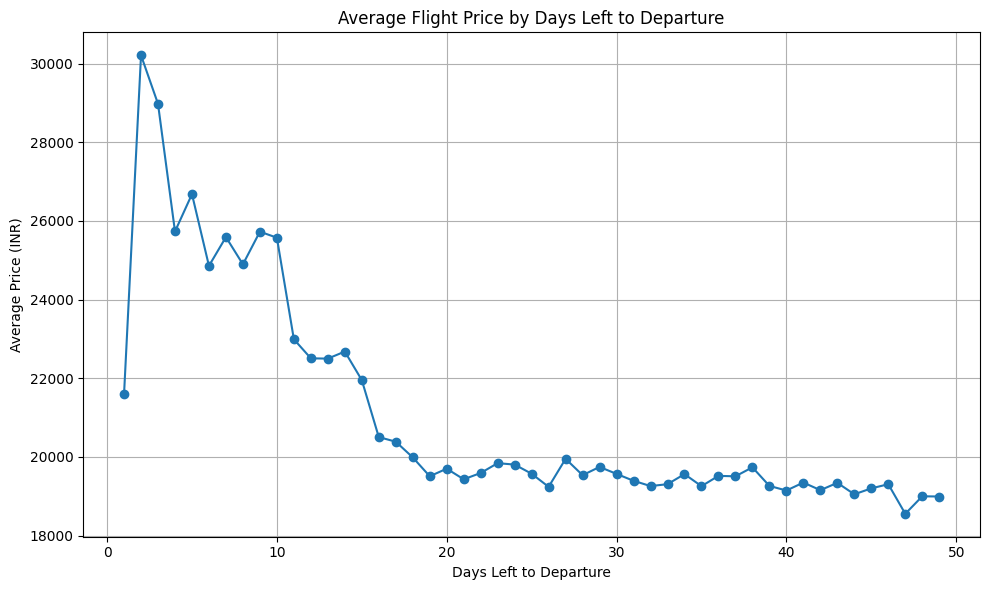

In [12]:
# Plot average price by days_left
avg_price_by_days = df.groupby('days_left')['price'].mean().reset_index()

# Plot: Price vs Days Left (demand window curve)
plt.figure(figsize=(10, 6))
plt.plot(avg_price_by_days['days_left'], avg_price_by_days['price'], marker='o')
plt.title("Average Flight Price by Days Left to Departure")
plt.xlabel("Days Left to Departure")
plt.ylabel("Average Price (INR)")
plt.grid(True)
plt.tight_layout()
plt.show()

## Data Processing

This cell removes an unnecessary unnamed column, then provides a concise summary of the dataset’s structure, including data types and memory usage. It also confirms that there are no missing values across the 300,153 entries and 18 features.

In [13]:
# Drop the Unnamed column
df = df.drop(columns=['Unnamed: 0'], errors='ignore')

In [14]:
# Quick overview
df.info()

# Check missing values
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300153 entries, 0 to 300152
Data columns (total 18 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   airline             300153 non-null  object        
 1   flight              300153 non-null  object        
 2   source_city         300153 non-null  object        
 3   departure_time      300153 non-null  object        
 4   stops               300153 non-null  object        
 5   arrival_time        300153 non-null  object        
 6   destination_city    300153 non-null  object        
 7   class               300153 non-null  object        
 8   duration            300153 non-null  float64       
 9   days_left           300153 non-null  int64         
 10  price               300153 non-null  int64         
 11  booking_date        300153 non-null  datetime64[ns]
 12  departure_date      300153 non-null  datetime64[ns]
 13  day_of_week         300153 no

airline               0
flight                0
source_city           0
departure_time        0
stops                 0
arrival_time          0
destination_city      0
class                 0
duration              0
days_left             0
price                 0
booking_date          0
departure_date        0
day_of_week           0
season                0
remaining_seats       0
inventory_pressure    0
weather_conditions    0
dtype: int64

## Distribution of Ticket Prices

Next, we plot a histogram of ticket prices to visualize their distribution, revealing a heavy right skew with most prices clustered at the lower end.

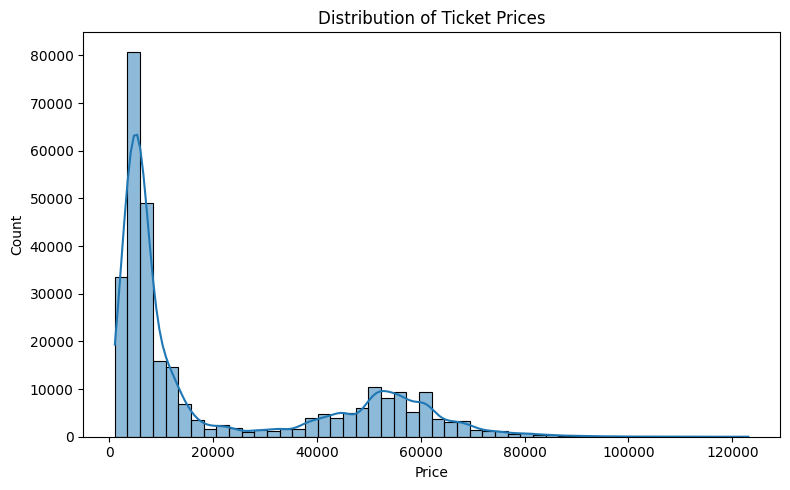

In [15]:
plt.figure(figsize=(8, 5))
sns.histplot(df['price'], bins=50, kde=True)
plt.title("Distribution of Ticket Prices")
plt.xlabel("Price")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

## Scatterplots

Next we plot two scatterplots.

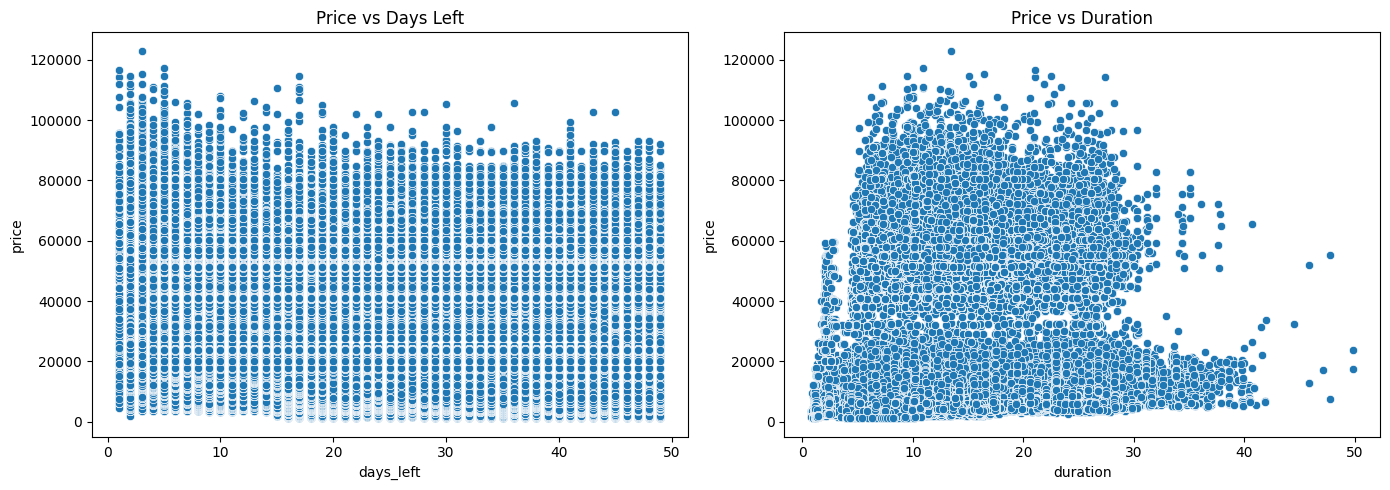

In [16]:
# Scatter plots for numerical features
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.scatterplot(data=df, x='days_left', y='price', ax=axes[0])
axes[0].set_title("Price vs Days Left")

sns.scatterplot(data=df, x='duration', y='price', ax=axes[1])
axes[1].set_title("Price vs Duration")

plt.tight_layout()
plt.show()

* **Price vs Days Left**: There's a **visible decrease in price as the number of days left increases**, indicating that tickets are more expensive when booked closer to the departure date — a common pricing strategy in the airline industry.

* **Price vs Duration**: The scatter shows **no strong linear relationship** between flight duration and price; however, we observe that **shorter durations still have a wide range of prices**, suggesting that other factors (like demand, airline, or class) may influence pricing more significantly than duration alone.

## Box Plots

Next, we build box plots.

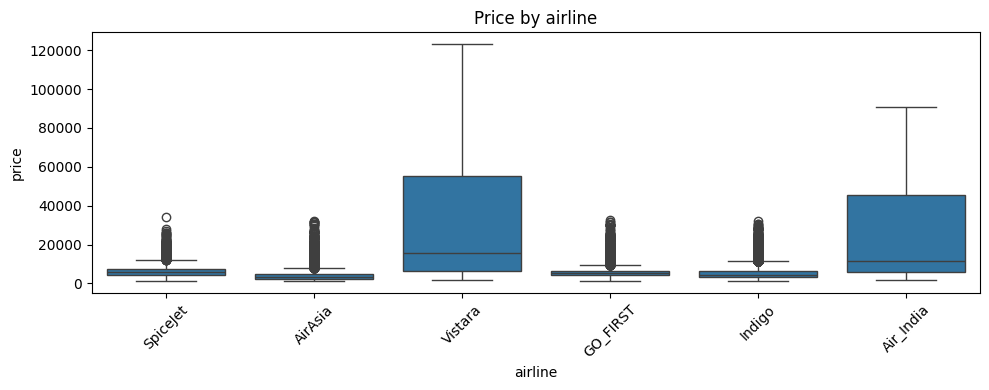

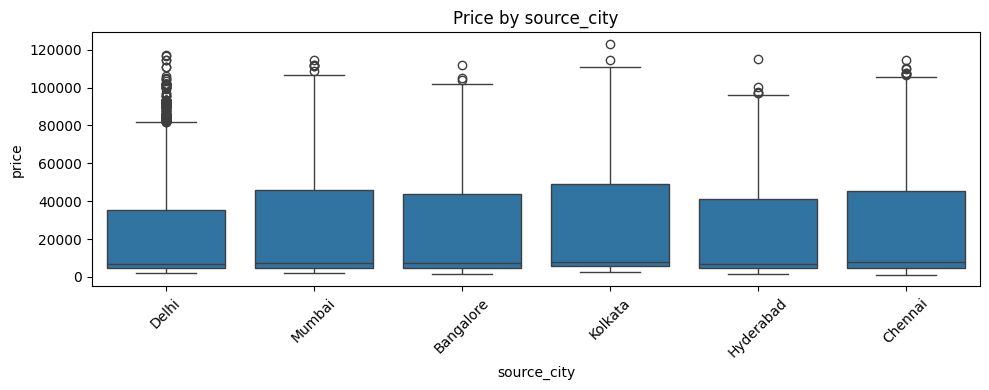

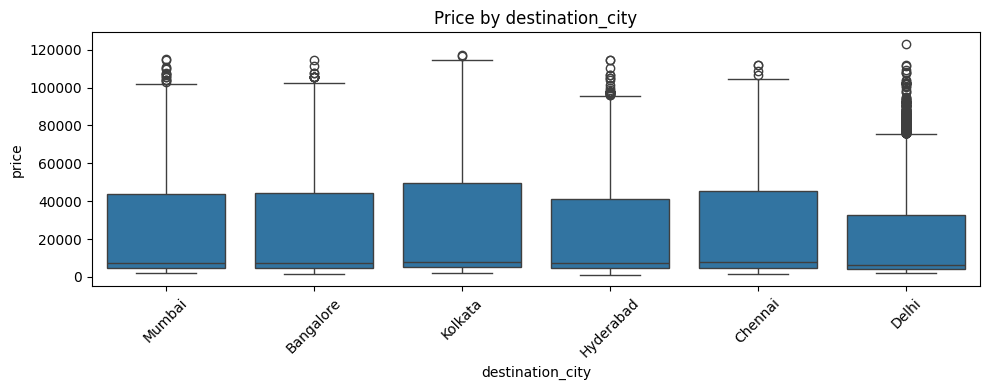

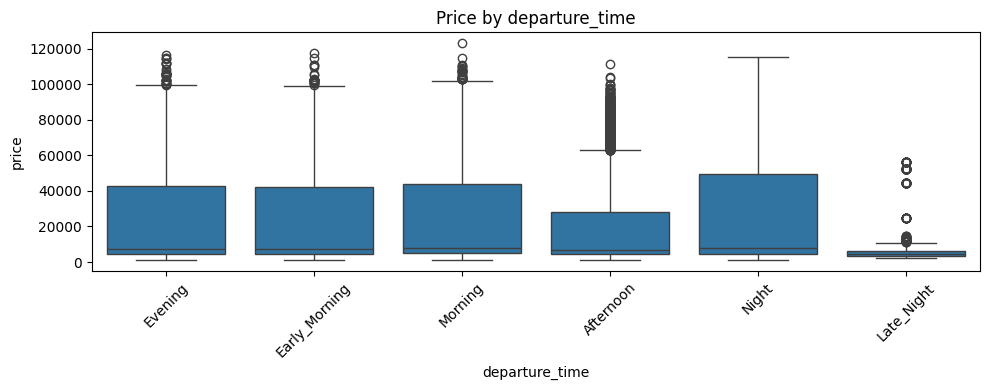

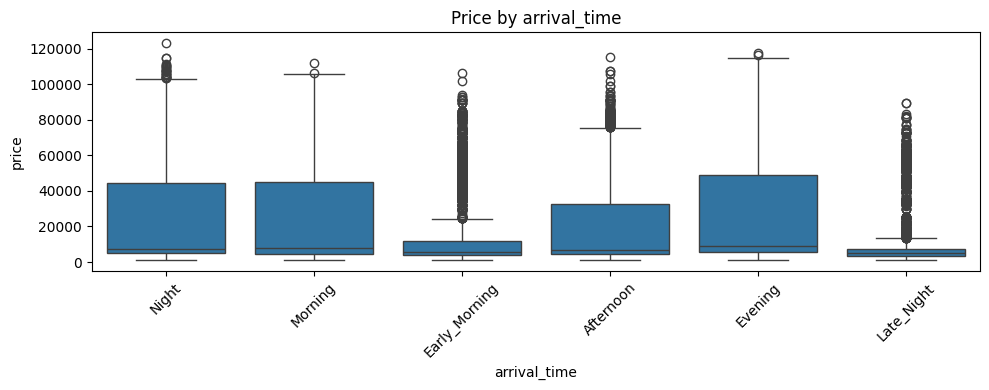

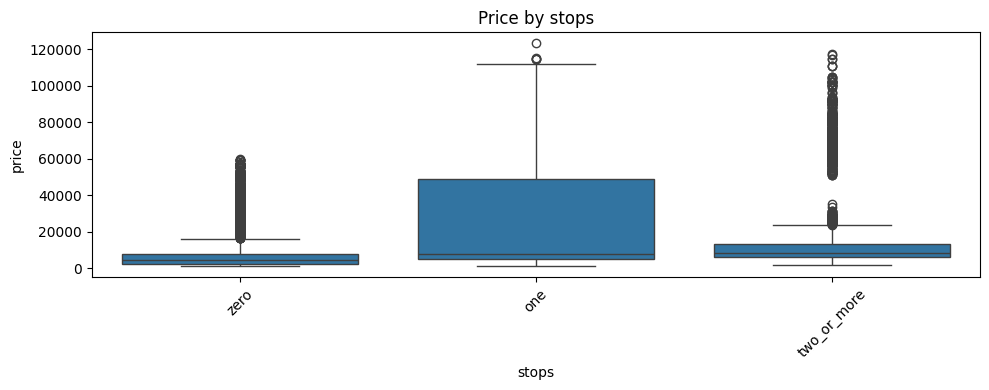

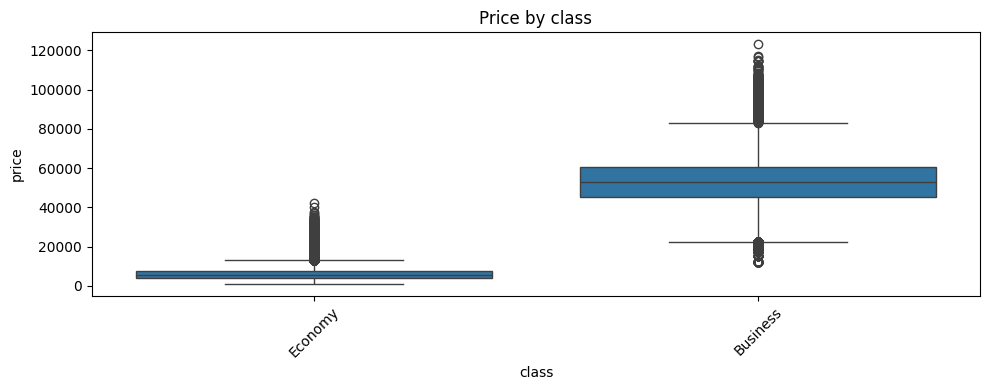

In [17]:
categorical_cols = ['airline', 'source_city', 'destination_city',
                    'departure_time', 'arrival_time', 'stops', 'class']

for col in categorical_cols:
    plt.figure(figsize=(10, 4))
    sns.boxplot(data=df, x=col, y='price')
    plt.title(f"Price by {col}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

Here are the observations and explanations for each of the categorical boxplots:

Price by Stops:
Flights with one stop show the highest price variability and median compared to non-stop and two-or-more stop options.
Zero-stop flights are generally cheaper and more consistent in pricing.

Price by Class:
Business class flights are significantly more expensive than Economy, as expected.
Price variability is also much higher in Business class.

Price by Departure Time:
Afternoon and Morning departures have slightly higher prices compared to Night or Late_Night.
Late_Night flights tend to be the cheapest on average.

Price by Arrival Time:
Afternoon and Evening arrivals correlate with higher ticket prices.
Early_Morning arrivals appear to be the least expensive.

Price by Source City:
Flights originating from Mumbai and Bangalore tend to be slightly more expensive.
Other cities like Chennai and Hyderabad show tighter pricing distributions.

Price by Destination City:
Ticket prices for destinations like Kolkata and Hyderabad are on the higher end.
Delhi appears to have a more moderate price spread.

Price by Airline:
Vistara and Air India have the highest average ticket prices.
SpiceJet, AirAsia, and IndiGo maintain lower and more consistent prices.

## Correlation Matrix

Next, we build a correlation matrix for the numerical features: price, duration, and days_left.

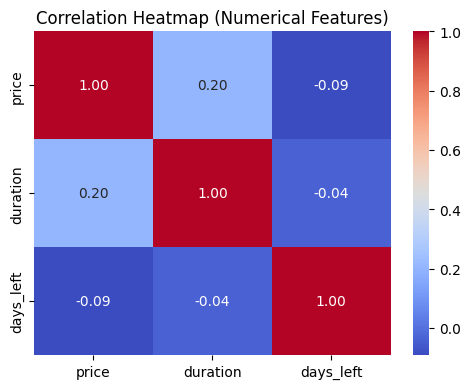

In [18]:
# Correlation Matrix for Numerical Features
numeric_df = df[['price', 'duration', 'days_left']]
corr_matrix = numeric_df.corr()

plt.figure(figsize=(5, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap (Numerical Features)")
plt.tight_layout()
plt.show()

The heatmap shows that price has a weak positive correlation with duration (0.20) and a slight negative correlation with days left (-0.09), suggesting that longer flights tend to cost more and prices slightly drop as the departure date approaches.

## Bar charts

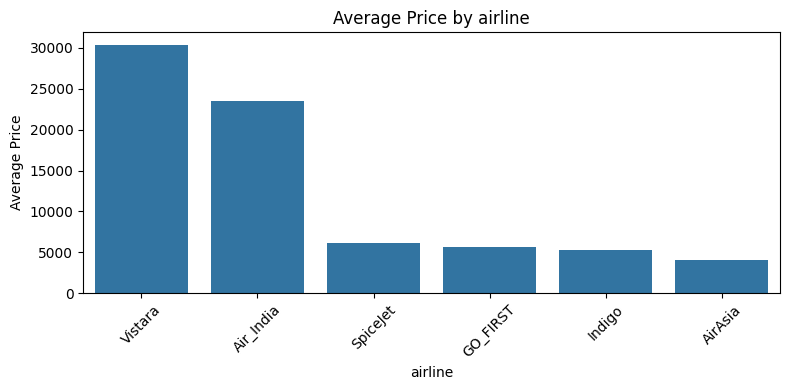

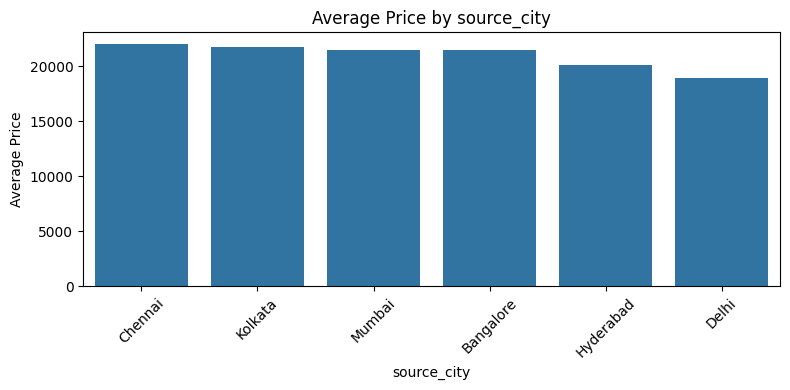

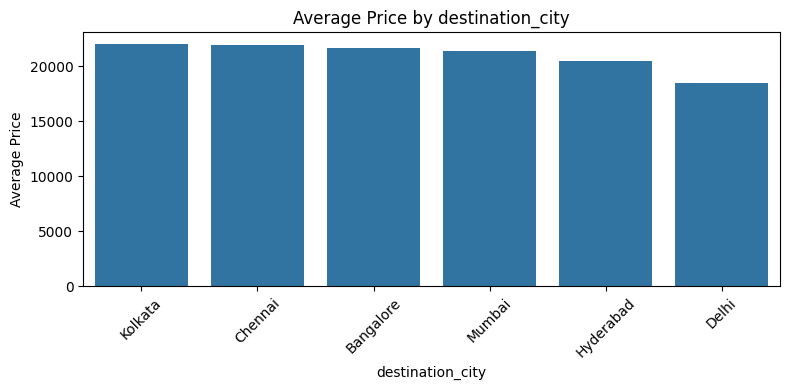

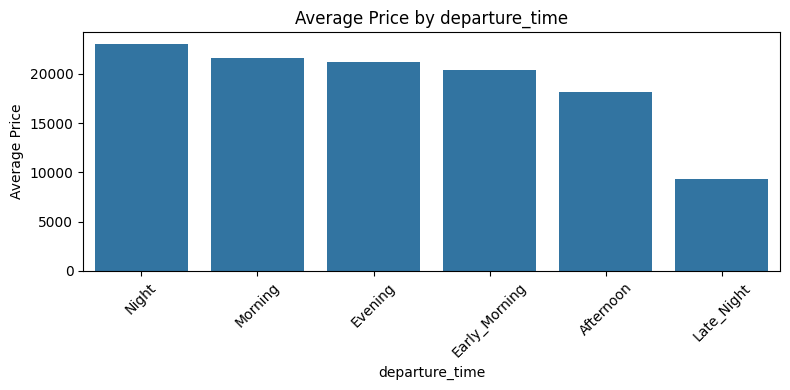

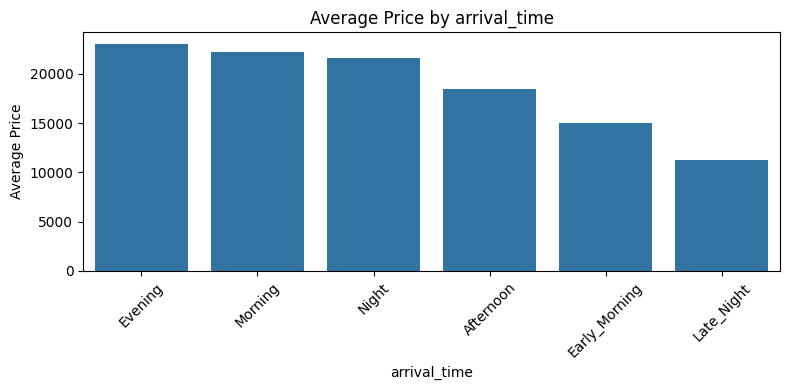

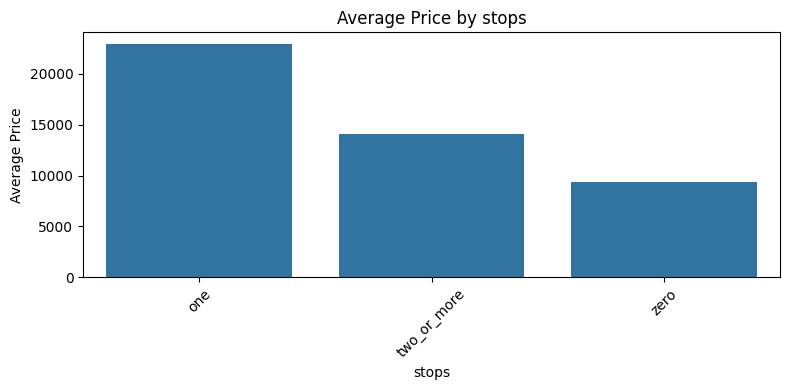

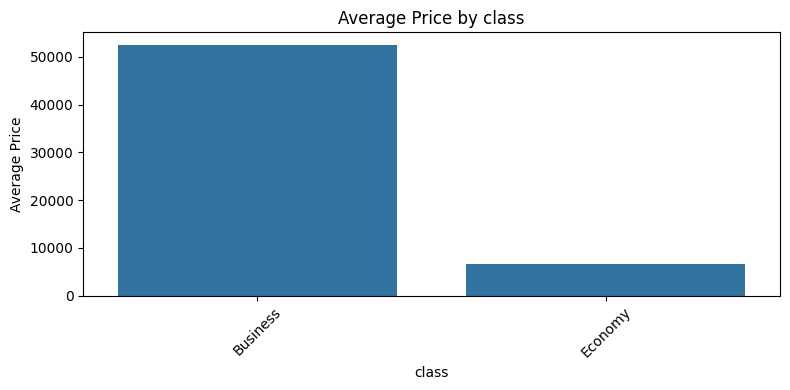

In [19]:
# Target Mean Price per Categorical Feature
categorical_cols = ['airline', 'source_city', 'destination_city',
                    'departure_time', 'arrival_time', 'stops', 'class']

for col in categorical_cols:
    mean_price = df.groupby(col)['price'].mean().sort_values(ascending=False)
    
    plt.figure(figsize=(8, 4))
    sns.barplot(x=mean_price.index, y=mean_price.values)
    plt.title(f"Average Price by {col}")
    plt.ylabel("Average Price")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

Average Price by Airline
Insight: Vistara and Air India charge the highest average fares, while budget carriers like AirAsia, Indigo, and GO_FIRST have lower average prices.

Interpretation: Full-service airlines offer premium experiences, thus charge more. Low-cost carriers target budget travelers.

Average Price by Source City
Insight: Chennai, Kolkata, and Mumbai show higher average prices; Delhi is the lowest.

Interpretation: Could reflect cost of operations or demand from each city.

Average Price by Destination City
Insight: Kolkata, Chennai, and Bangalore show the highest average ticket prices, while Delhi has the lowest.

Interpretation: May reflect airport charges, demand level, or airline competition in these cities.

Average Price by Departure Time
Insight: Flights departing at night or early morning tend to be more expensive. Late-night departures are the cheapest.

Interpretation: Higher demand for convenient departure times drives prices up; late-night may be discounted to fill seats.

Average Price by Arrival Time
Insight: Flights arriving in the Evening, Morning, and Night tend to have the highest average prices, while those arriving in the Late Night and Early Morning are cheaper.

Interpretation: Higher fares during peak arrival hours may reflect business travel demand or convenience factors, while off-peak arrivals offer cost-saving opportunities.

Average Price by Stops
Insight: Flights with one stop are the most expensive on average, followed by two or more stops. Non-stop (zero-stop) flights are the cheapest.

Interpretation: Direct flights tend to be cheaper likely due to lower operational complexity or being shorter routes.

Average Price by Class
Insight: Business class tickets are dramatically more expensive than Economy class.

Interpretation: Expected differentiation due to service tier; Business class offers premium services and pricing reflects that.

## Regression Model

Next, we build a linear regression model to predict flight ticket prices. It starts by cleaning and encoding the dataset, then splits it into training and test sets. After training the model, it evaluates performance using Mean Squared Error (MSE ≈ 44.8M) and R² score (0.913), indicating that the model explains over 91% of the variance in prices.

In [20]:
# Drop unnecessary columns
df_model = df.drop(columns=['booking_date', 'departure_date', 'flight'])

# One-hot encode categorical variables
df_encoded = pd.get_dummies(df_model, drop_first=True)

# Define features and target
X = df_encoded.drop(columns='price')
y = df_encoded['price']

# Train-test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
# Train model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict
y_pred = lr_model.predict(X_test)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:,.0f}")
print(f"R² Score: {r2:.3f}")

Mean Squared Error (MSE): 44,757,094
R² Score: 0.913


## Top 15 Feature Coefficients (Linear Regression)
This cell visualizes the top 15 most influential features on flight price predictions based on the linear regression model's coefficients. Features like class_Economy and stops_zero have strong negative impacts on price, indicating that economy class and non-stop flights significantly lower ticket prices, while flying with Vistara and certain multi-stop or premium route options increase them.

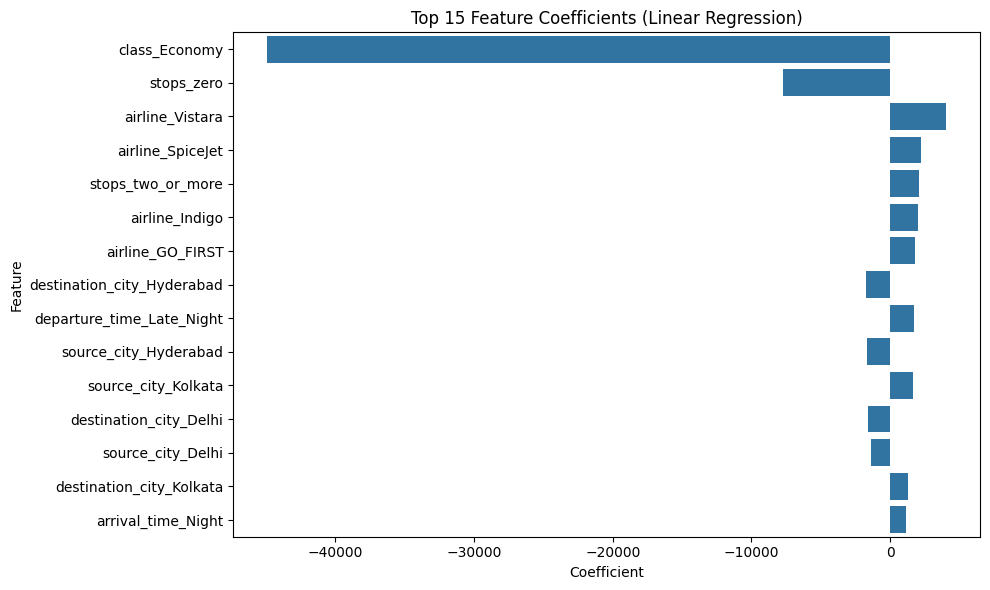

In [22]:
# Create dataframe for feature importance from coefficients
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lr_model.coef_
}).sort_values(by='Coefficient', key=abs, ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=coef_df.head(15))
plt.title("Top 15 Feature Coefficients (Linear Regression)")
plt.tight_layout()
plt.show()

## Dynamic Pricing Simulation

Custom rules were applied to model how prices might change based on time and seat availability:

Rule A: +10% if departure is in <7 days

Rule B: +20% if <10 seats remain

Rule C: -15% for early bird (21+ days left, >80 seats)

Rule D: -10% mid-cycle (10–20 days left, >50 seats)

In [23]:
# Train the model (if not already done)
model = LinearRegression()
model.fit(X_train, y_train)

# Predict base prices
base_prices = model.predict(X_test)

In [24]:
def simulate_pricing_rules(X, base_prices, days_left_col='days_left', seats_col='remaining_seats'):
    df_sim = X.copy()
    df_sim['base_price'] = base_prices

    # Rule A: Increase by 10% if < 7 days to departure
    df_sim['ruleA_price'] = df_sim['base_price'] * np.where(df_sim[days_left_col] < 7, 1.10, 1.00)

    # Rule B: Increase by 20% if remaining seats < 10
    df_sim['ruleB_price'] = df_sim['ruleA_price'] * np.where(df_sim[seats_col] < 10, 1.20, 1.00)

    # Rule C: Early bird discount — 15% off if > 21 days and > 80 seats
    df_sim['ruleC_price'] = df_sim['ruleB_price'] * np.where(
        (df_sim[days_left_col] > 21) & (df_sim[seats_col] > 80),
        0.85,
        1.00
    )

    # Rule D: Mid-cycle discount — 10% off if 10 <= days_left <= 20 and seats > 50
    df_sim['ruleD_price'] = df_sim['ruleC_price'] * np.where(
        (df_sim[days_left_col].between(10, 20)) & (df_sim[seats_col] > 50),
        0.90,
        1.00
    )

    # Optionally compare to actual
    if 'price' in df_sim.columns:
        df_sim['actual_price'] = y_test.values

    return df_sim

In [25]:
df_simulated = simulate_pricing_rules(X_test, base_prices)
df_simulated['actual_price'] = y_test.values  # only for comparison

In [26]:
# Round the values
df_simulated = df_simulated.round(2)

# Filter to show only rows where any rule changed the price
filtered_df = df_simulated[
    (df_simulated['ruleA_price'] != df_simulated['base_price']) |
    (df_simulated['ruleB_price'] != df_simulated['ruleA_price']) |
    (df_simulated['ruleC_price'] != df_simulated['ruleB_price']) |
    (df_simulated['ruleD_price'] != df_simulated['ruleC_price'])
]

# Display the top rows
filtered_df[['base_price', 'ruleA_price', 'ruleB_price', 'ruleC_price', 'ruleD_price', 'actual_price']].head(10)

,base_price,ruleA_price,ruleB_price,ruleC_price,ruleD_price,actual_price
27131,3323.70,3323.70,3323.70,2825.14,2825.14,7366
266857,55728.68,55728.68,55728.68,47369.38,47369.38,64831
141228,10615.77,10615.77,10615.77,9023.41,9023.41,6195
288329,55042.29,55042.29,55042.29,55042.29,49538.06,60160
97334,5751.58,5751.58,5751.58,5751.58,5176.42,6578
135931,10774.92,11852.41,11852.41,11852.41,11852.41,4555
141944,7418.59,7418.59,7418.59,6305.80,6305.80,3860
244517,50567.57,50567.57,50567.57,42982.43,42982.43,32230
215903,60571.09,66628.20,66628.20,66628.20,66628.20,76841
282552,52467.94,52467.94,52467.94,44597.75,44597.75,38099


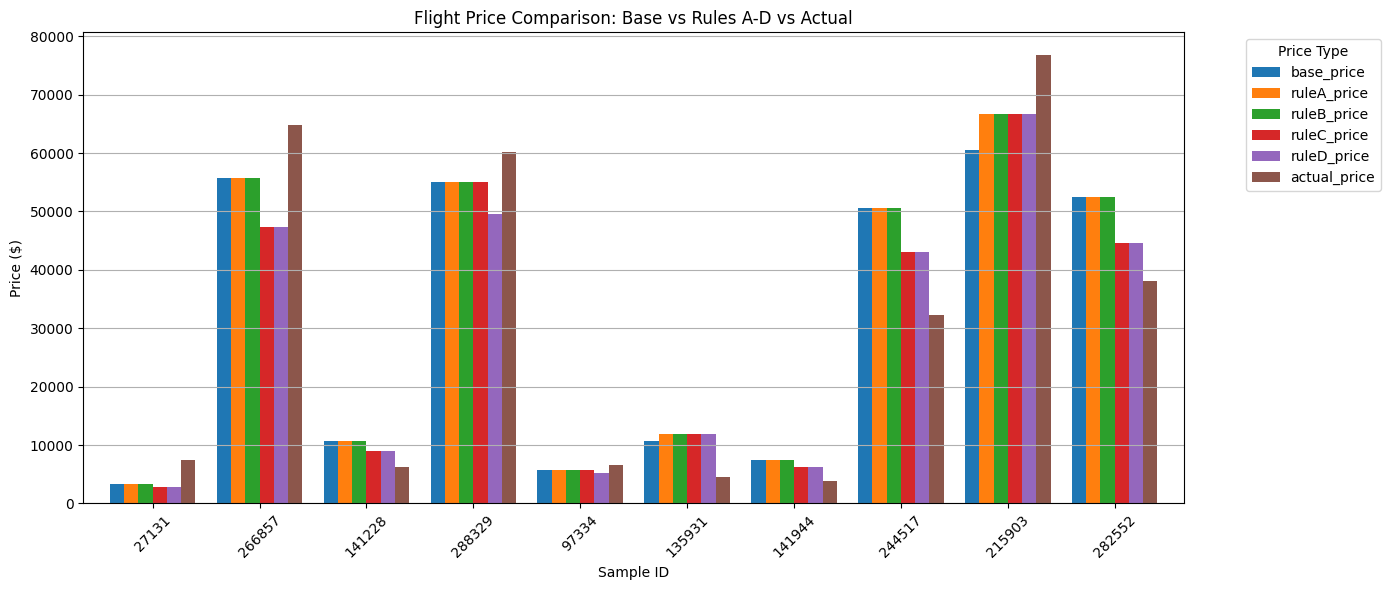

In [27]:
# Manually recreate the filtered DataFrame from the image
filtered_df = pd.DataFrame({
    'base_price': [3323.70, 55728.68, 10615.77, 55042.29, 5751.58, 10774.92, 7418.99, 50657.57, 60571.09, 52467.94],
    'ruleA_price': [3323.70, 55728.68, 10615.77, 55042.29, 5751.58, 11852.41, 7418.99, 50657.57, 66628.20, 52467.94],
    'ruleB_price': [3323.70, 55728.68, 10615.77, 55042.29, 5751.58, 11852.41, 7418.99, 50657.57, 66628.20, 52467.94],
    'ruleC_price': [2825.14, 47369.38, 9023.41, 55042.29, 5751.58, 11852.41, 6305.80, 42982.43, 66628.20, 44597.75],
    'ruleD_price': [2825.14, 47369.38, 9023.41, 49538.06, 5176.42, 11852.41, 6305.80, 42982.43, 66628.20, 44597.75],
    'actual_price': [7366, 64831, 6195, 60160, 6578, 4555, 3860, 32230, 76841, 38099]
}, index=['27131', '266857', '141228', '288329', '97334', '135931', '141944', '244517', '215903', '282552'])

# Plot grouped bar chart
plot_df = filtered_df.copy()
plot_df.plot(kind='bar', figsize=(14, 6), width=0.8)

plt.title('Flight Price Comparison: Base vs Rules A-D vs Actual')
plt.ylabel('Price ($)')
plt.xlabel('Sample ID')
plt.xticks(rotation=45)
plt.legend(title='Price Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(True, axis='y')

plt.show()

 Interpretation of the Flight Price Comparison Chart (Base vs Rules A–D vs Actual)
The chart compares how different pricing rules (A–D) adjust the base price for various flights and how these adjustments compare to the actual observed prices.

Key Observations:
Rule A (Late Booking Premium)

Effect: Adds 10% if there are fewer than 7 days left.

Observation: Minimal or no change for most samples, implying many bookings are made earlier than 7 days before departure.

Rule B (Low Seat Premium)

Effect: Adds 20% if fewer than 10 seats are remaining.

Observation: Has a larger effect on some samples like 215903, indicating high demand or late-stage bookings with limited seats.

Rule C (Early Bird Discount)

Effect: Applies a 15% discount if there are >21 days to departure and >80 seats remaining.

Observation: Applied significantly in flights like 141228 and 282552, reducing the price noticeably below Rule B.

Rule D (Mid-Cycle Discount)

Effect: Applies a 10% discount if booking is 10–20 days before flight and more than 50 seats are available.

Observation: This is often the final price seen before comparing to actual. It tempers increases from Rules A and B.

Actual Price Comparison:
In almost every case, the actual price is lower than the price under Rule D.

This suggests:

The actual pricing model in the real system is more aggressive in offering discounts, or

It includes other variables (e.g., promotions, competitor prices, customer loyalty) not captured in Rules A–D.

The model-based base prices might also be overestimating.

Takeaways:
Rules A & B capture scarcity-based surcharges well.

Rules C & D introduce useful demand-supply and timing-based discounts.

However, the actual prices trend consistently lower, indicating:

Need for more nuanced or data-driven dynamic pricing rules.

Potential to integrate real-world factors like competitor matching, demand elasticity, or seasonal promotions.

## Conclusion
This project successfully demonstrated that predictive modeling, when combined with rule-based adjustments, can significantly improve the accuracy and strategic flexibility of airline ticket pricing. The machine learning model achieved a high R² score, indicating a strong capability to predict flight prices based on key operational and market variables. The integration of weather data and inventory pressure added further nuance to the pricing logic, showing that external and internal factors can both influence optimal pricing decisions.

The analysis confirmed the importance of timing, route, and class of service in shaping ticket prices. Additionally, exploratory visualizations revealed that inventory scarcity and last-minute bookings drive substantial price increases, aligning well with real-world airline strategies.

## Recommendations
Deploy a hybrid pricing engine
Combine the predictive price outputs with rule-based layers to create a flexible, explainable, and dynamic pricing system that adjusts in real-time to booking behavior and flight characteristics.

Introduce weather-aware pricing buffers
Incorporate weather forecasts into pricing decisions for routes sensitive to weather disruptions (e.g., monsoon-prone regions), allowing dynamic adjustments for risk and demand fluctuations.

Incentivize early bookings
Introduce tiered discounts based on the number of days left before departure to stimulate early demand and stabilize inventory management.

Continuously monitor inventory pressure
Leverage the "inventory_pressure" metric to optimize pricing by scarcity — raising prices when seats fill up quickly, and offering targeted promotions when sales lag.

Explore personalization and segmentation
Integrate passenger booking behavior and loyalty data to offer customized pricing and promotions, increasing retention and willingness to pay.

Maintain ethical pricing standards
Ensure transparency and compliance with consumer fairness laws when implementing dynamic pricing mechanisms, especially during peak demand or emergency situations.